# Code for Sentiment Analysis on the models' generated responses

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import textwrap

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel, BertTokenizer, AdamW
import torch
import os
from transformers import AutoTokenizer, AutoModelForCausalLM

from openai import OpenAI
from google.colab import userdata, drive

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
# Mount drive location so we don't have to upload data every time
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Ensure we are in the correct folder
directory = '/content/drive/My Drive/MIT NLP Project/model_responses'

In [5]:
dem_1976 = pd.read_csv(os.path.join(directory, 'dem_1976_results.csv'))
dem_2016 = pd.read_csv(os.path.join(directory, 'dem_2016_results.csv'))

rep_1976 = pd.read_csv(os.path.join(directory, 'rep_1976_results.csv'))
rep_2016 = pd.read_csv(os.path.join(directory, 'rep_2016_results.csv'))

In [5]:
dem_1976

,Question,Model_Response
0,Why do you believe you are fit to be the next ...,I dont think either one of us would be sitting...
1,What is your overarching vision for the country?,"Well, the first thing is I believe in America...."
2,What is your plan to manage inflation and ensu...,"Inflation, as we all know, is caused ultimatel..."
3,How will you create jobs and reduce unemployme...,I believe that this forty-one percent unemploy...
4,What steps will you take to balance the federa...,I have set a target for us to balance the fede...
...,...,...
135,How will you restore trust in government and e...,There are two essential things that have to be...
136,What policies will you pursue to ensure equali...,"No, I uh, had forgotten he had a two-minute re..."
137,How will you lead the country through challeng...,I would meet with every chairman of every cong...
138,What is your plan to manage immigration in a w...,The first thing that you have to do is to cont...


In [6]:
# Split data by sentences for more in-depth sentiment analysis
def split_dialogue(row, max_length=250):
    # Split the dialogue into chunks based on input max_length
    chunks = textwrap.wrap(row['Model_Response'], max_length)

    return pd.DataFrame({
        'Question': [row['Question']] * len(chunks),
        'Model_Response': chunks
    })

# Iterrate through each df and apply split_dialogue
dem_1976_split = pd.concat([split_dialogue(row) for _, row in dem_1976.iterrows()], ignore_index=True)
dem_2016_split = pd.concat([split_dialogue(row) for _, row in dem_2016.iterrows()], ignore_index=True)
rep_1976_split = pd.concat([split_dialogue(row) for _, row in rep_1976.iterrows()], ignore_index=True)
rep_2016_split = pd.concat([split_dialogue(row) for _, row in rep_2016.iterrows()], ignore_index=True)


# VADER Sentiment Analysis

In [7]:
rep_2016_split

,Question,Model_Response
0,Why do you believe you are fit to be the next ...,Why do you believe you are fit to be the next ...
1,What is your overarching vision for the country?,I want a beautiful life for this country. [app...
2,What is your plan to manage inflation and ensu...,Im going to fix it. Its broken. Its destroyed....
3,How will you create jobs and reduce unemployme...,Im going to create a lot of jobs. Its going to...
4,What steps will you take to balance the federa...,"I will I've made a commitment for 8 years, Ill..."
...,...,...
239,How will you lead the country through challeng...,"All right, thank you, Secretary Clinton. So I ..."
240,What is your plan to manage immigration in a w...,"We will, number one, secure the border. Number..."
241,What is your plan to manage immigration in a w...,open border policies. We'll restore my remain-...
242,How will you ensure equal opportunities for ma...,I will open every African American and Hispani...


In [8]:
# List of df_names to iterature through

df_list = [dem_1976_split, dem_2016_split, rep_1976_split, rep_2016_split]
# Perform VADER sentiment analysis
sia = SentimentIntensityAnalyzer()

for df in df_list:
    df['vader_scores'] = df['Model_Response'].apply(lambda x: sia.polarity_scores(str(x)))
    df['compound'] = df['vader_scores'].apply(lambda score_dict: score_dict['compound'])

In [9]:
dem_1976_split

,Question,Model_Response,vader_scores,compound
0,Why do you believe you are fit to be the next ...,I dont think either one of us would be sitting...,"{'neg': 0.047, 'neu': 0.85, 'pos': 0.103, 'com...",0.4504
1,Why do you believe you are fit to be the next ...,The country may be becoming frustrated with po...,"{'neg': 0.108, 'neu': 0.756, 'pos': 0.136, 'co...",0.0992
2,Why do you believe you are fit to be the next ...,the most important decisions they ever had to ...,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'comp...",0.5642
3,Why do you believe you are fit to be the next ...,halfway there. And I think Ive earned your con...,"{'neg': 0.064, 'neu': 0.641, 'pos': 0.295, 'co...",0.8720
4,What is your overarching vision for the country?,"Well, the first thing is I believe in America....","{'neg': 0.034, 'neu': 0.779, 'pos': 0.187, 'co...",0.7430
...,...,...,...,...
910,How will you ensure equal opportunities for ma...,The efforts that this government has already m...,"{'neg': 0.031, 'neu': 0.916, 'pos': 0.054, 'co...",0.2540
911,How will you ensure equal opportunities for ma...,groups. Well have a small business compliance ...,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.5994
912,How will you ensure equal opportunities for ma...,"handicapped firms, to get their share of gover...","{'neg': 0.0, 'neu': 0.947, 'pos': 0.053, 'comp...",0.2960
913,How will you ensure equal opportunities for ma...,important goals of my presidency And over a de...,"{'neg': 0.0, 'neu': 0.892, 'pos': 0.108, 'comp...",0.4767


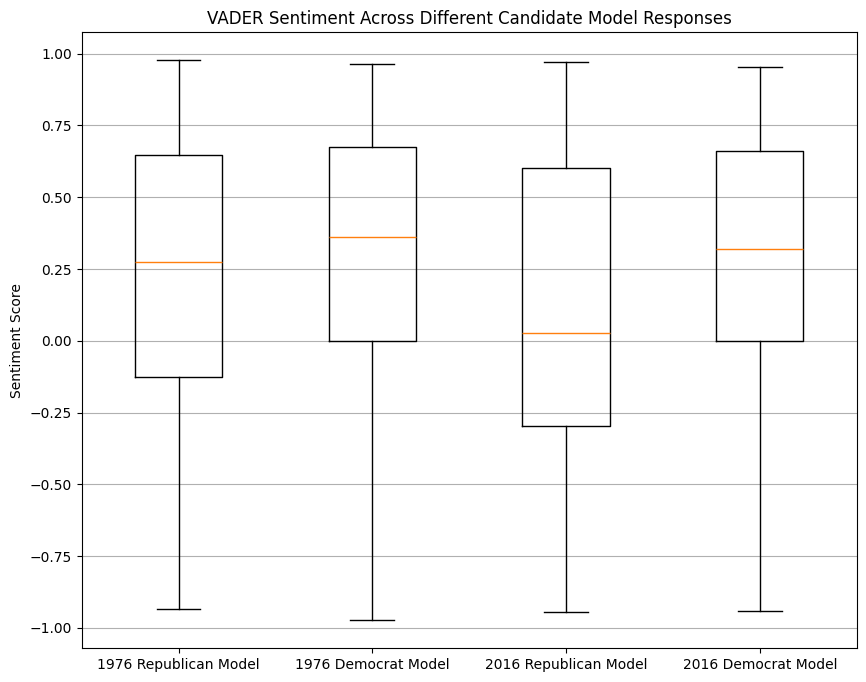

In [9]:
data = [rep_1976_split['compound'], dem_1976_split['compound'], rep_2016_split['compound'], dem_2016_split['compound']]

plt.figure(figsize=(10,8))
plt.boxplot(data, labels=['1976 Republican Model', '1976 Democrat Model', '2016 Republican Model', '2016 Democrat Model'])

plt.title('VADER Sentiment Across Different Candidate Model Responses')
plt.ylabel('Sentiment Score')
plt.grid(axis='y')
#plt.xticks(rotation=45)
plt.show()


# ROBERTA Sentiment Analysis

In [ ]:
# Perform sentiment analysis using ROBERTA model from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to("cuda")

# Polarity score = sentiment score
def get_polarity_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to("cuda")
    outputs = model(**inputs)
    
    # Scores are probabilities for each class (positive, negative)
    scores = outputs.logits[0].softmax(dim=0).tolist()
    polarity_score = scores[2] - scores[0]
    return polarity_score

# Apply polarity score calculation to each model response
for df in df_list:
    df['ROBERTA_score'] = df['Model_Response'].apply(get_polarity_score)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

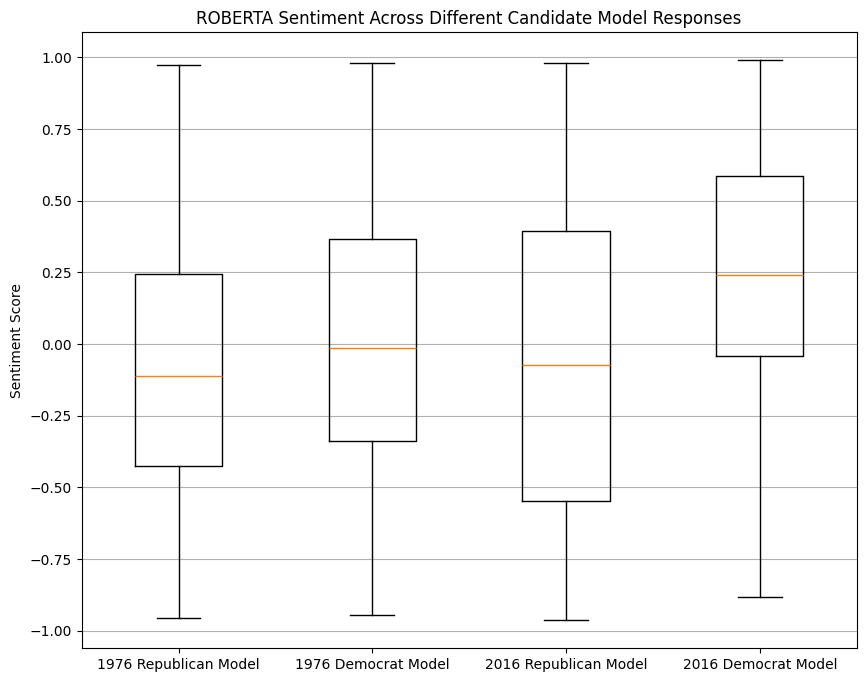

In [11]:
data = [rep_1976_split['ROBERTA_score'], dem_1976_split['ROBERTA_score'], rep_2016_split['ROBERTA_score'], dem_2016_split['ROBERTA_score']]

plt.figure(figsize=(10,8))
plt.boxplot(data, labels=['1976 Republican Model', '1976 Democrat Model', '2016 Republican Model', '2016 Democrat Model'])

plt.title('ROBERTA Sentiment Across Different Candidate Model Responses')
plt.ylabel('Sentiment Score')
plt.grid(axis='y')
#plt.xticks(rotation=45)
plt.show()


# GPT4-o Mini Sentiment Analysis

In [12]:
# michelle's API key
api_key_me = userdata.get('NLP_OPENAI')
client = OpenAI(api_key=api_key_me)

def chatWithGPT(prompt):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content

# Define a function to categorize each response using GPT-4o-mini
def categorize_response(text):
    prompt = (f"Please analyze the sentiment of the following text. Provide a score between -1 and 1, where -1 represents very negative sentiment, 0 represents neutral sentiment, and 1 represents very positive sentiment. Only give the score, no explanation. Here is the text: {text}")
    # Call the GPT-4 o mini API
    return chatWithGPT(prompt)


In [14]:
# Set up a counter to track progress throughout the run
processed_count = 0

# Saving every 100 rows
for i in range(len(rep_2016_split)):
    rep_2016_split.at[i, 'gpt_4_mini_score'] = categorize_response(rep_2016_split.at[i, 'Model_Response'])

    # Increment the counter
    processed_count += 1

    # Print progress update every 10 rows
    if processed_count % 100 == 0:
        print(f"Processed {processed_count}/{len(rep_2016_split)} rows")

    # Save progress every 100 rows
    if processed_count % 100 == 0:
        rep_2016_split.to_csv('rep_2016_sentiments.csv', index=False)
        print(f"Checkpoint: Saved progress at {processed_count} rows")

# Save final result after all rows are processed
rep_2016_split.to_csv('rep_2016_sentiments.csv', index=False)
print("Processing complete. Final CSV saved.")

Processed 100/244 rows
Checkpoint: Saved progress at 100 rows
Processed 200/244 rows
Checkpoint: Saved progress at 200 rows
Processing complete. Final CSV saved.


In [19]:
rep_2016_split= pd.read_csv("rep_2016_sentiments.csv")
dem_2016_split= pd.read_csv("dem_2016_sentiments.csv")
rep_1976_split= pd.read_csv("rep_1976_sentiments.csv")
dem_1976_split= pd.read_csv("dem_1976_sentiments.csv")

In [38]:
dem_1976_split

,Question,Model_Response,vader_scores,compound,ROBERTA_score,gpt_4_mini_score
0,Why do you believe you are fit to be the next ...,I dont think either one of us would be sitting...,"{'neg': 0.047, 'neu': 0.85, 'pos': 0.103, 'com...",0.4504,-0.495575,0.3
1,Why do you believe you are fit to be the next ...,The country may be becoming frustrated with po...,"{'neg': 0.108, 'neu': 0.756, 'pos': 0.136, 'co...",0.0992,-0.296837,0.1
2,Why do you believe you are fit to be the next ...,the most important decisions they ever had to ...,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'comp...",0.5642,0.514393,0.3
3,Why do you believe you are fit to be the next ...,halfway there. And I think Ive earned your con...,"{'neg': 0.064, 'neu': 0.641, 'pos': 0.295, 'co...",0.8720,0.584500,0.5
4,What is your overarching vision for the country?,"Well, the first thing is I believe in America....","{'neg': 0.034, 'neu': 0.779, 'pos': 0.187, 'co...",0.7430,0.926189,0.8
...,...,...,...,...,...,...
910,How will you ensure equal opportunities for ma...,The efforts that this government has already m...,"{'neg': 0.031, 'neu': 0.916, 'pos': 0.054, 'co...",0.2540,-0.099985,0.4
911,How will you ensure equal opportunities for ma...,groups. Well have a small business compliance ...,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.5994,0.028323,0
912,How will you ensure equal opportunities for ma...,"handicapped firms, to get their share of gover...","{'neg': 0.0, 'neu': 0.947, 'pos': 0.053, 'comp...",0.2960,0.140893,0.3
913,How will you ensure equal opportunities for ma...,important goals of my presidency And over a de...,"{'neg': 0.0, 'neu': 0.892, 'pos': 0.108, 'comp...",0.4767,0.753726,0.5


In [56]:
dem_1976_split['gpt_4_mini_score'] = dem_1976_split['gpt_4_mini_score'].astype(float)
rep_1976_split['gpt_4_mini_score'] = rep_1976_split['gpt_4_mini_score'].astype(float)
rep_2016_split['gpt_4_mini_score'] = rep_2016_split['gpt_4_mini_score'].astype(float)
dem_2016_split['gpt_4_mini_score'] = dem_2016_split['gpt_4_mini_score'].astype(float)

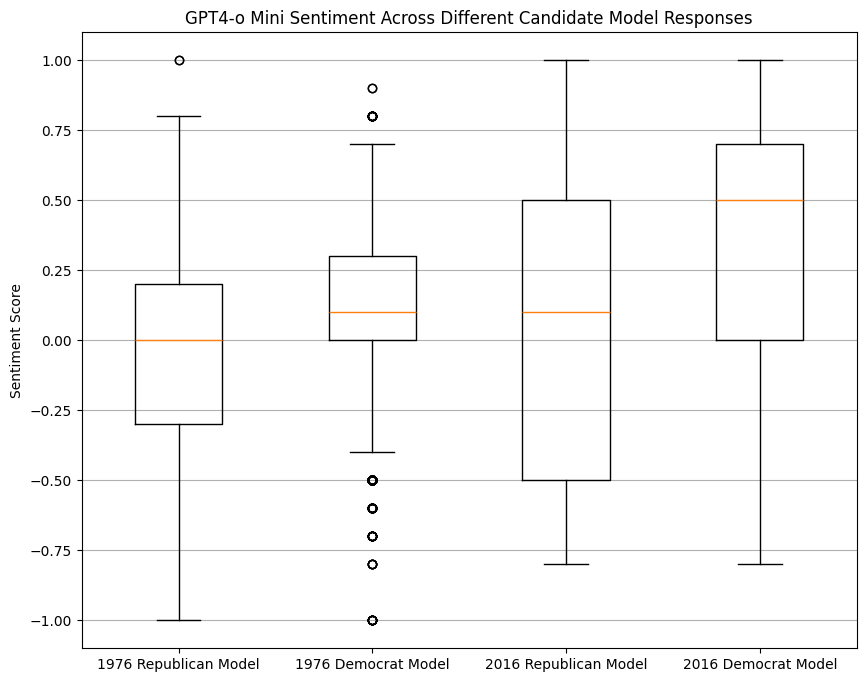

In [57]:
data = [rep_1976_split['gpt_4_mini_score'], dem_1976_split['gpt_4_mini_score'], rep_2016_split['gpt_4_mini_score'], dem_2016_split['gpt_4_mini_score']]

plt.figure(figsize=(10,8))
plt.boxplot(data, labels=['1976 Republican Model', '1976 Democrat Model', '2016 Republican Model', '2016 Democrat Model'])

plt.title('GPT4-o Mini Sentiment Across Different Candidate Model Responses')
plt.ylabel('Sentiment Score')
plt.grid(axis='y')
#plt.xticks(rotation=45)
plt.show()


In [62]:
rep_2016_split.to_csv("rep_2016_sentiments.csv")
dem_2016_split.to_csv("dem_2016_sentiments.csv")
rep_1976_split.to_csv("rep_1976_sentiments.csv")
dem_1976_split.to_csv("dem_1976_sentiments.csv")